# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
"""
Based on the work of Waleed Abdulla (Matterport)
Modified by github.com/GustavZ
"""
# python 2 compability
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import random
import math
import re
import datetime
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mmrcnn import utils
from mmrcnn import visualize
from mmrcnn.visualize import display_images
import mmrcnn.model as modellib
from mmrcnn.model import log

%matplotlib inline 

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "data/coco/imgs/")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
DEFAULT_WEIGHTS = os.path.join(ROOT_DIR, "mobile_mask_rcnn_coco.h5")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

[(1.0, 0.0, 0.0), (1.0, 0.07407407407407407, 0.0), (1.0, 0.14814814814814814, 0.0), (1.0, 0.2222222222222222, 0.0), (1.0, 0.2962962962962963, 0.0), (1.0, 0.37037037037037035, 0.0), (1.0, 0.4444444444444444, 0.0), (1.0, 0.5185185185185185, 0.0), (1.0, 0.5925925925925926, 0.0), (1.0, 0.6666666666666666, 0.0), (1.0, 0.7407407407407407, 0.0), (1.0, 0.8148148148148148, 0.0), (1.0, 0.8888888888888888, 0.0), (1.0, 0.9629629629629629, 0.0), (0.962962962962963, 1.0, 0.0), (0.8888888888888888, 1.0, 0.0), (0.8148148148148149, 1.0, 0.0), (0.7407407407407409, 1.0, 0.0), (0.6666666666666667, 1.0, 0.0), (0.5925925925925926, 1.0, 0.0), (0.5185185185185186, 1.0, 0.0), (0.44444444444444464, 1.0, 0.0), (0.37037037037037046, 1.0, 0.0), (0.2962962962962963, 1.0, 0.0), (0.22222222222222232, 1.0, 0.0), (0.14814814814814836, 1.0, 0.0), (0.07407407407407418, 1.0, 0.0), (0.0, 1.0, 0.0), (0.0, 1.0, 0.07407407407407396), (0.0, 1.0, 0.14814814814814792), (0.0, 1.0, 0.22222222222222232), (0.0, 1.0, 0.29629629629629

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
# Override the training configurations with a few
# changes for inferencing.
import coco
config = coco.CocoConfig()
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    POST_NMS_ROIS_INFERENCE = 100

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       mobilenetv1
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]


## Create Model and Load Trained Weights

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
#DEVICE = "/cpu:0"
DEVICE = "/gpu:0"

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"
#TEST_MODE = "training"

In [4]:
# Create model in inference mode
#with tf.device(DEVICE):
model = modellib.MaskRCNN(mode=TEST_MODE, model_dir=MODEL_DIR,config=config)
# Set path to model weights
weights_path = DEFAULT_WEIGHTS
#weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

W0922 18:36:45.080046 4605121984 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 18:36:45.109448 4605121984 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 18:36:45.142796 4605121984 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 18:36:45.144253 4605121984 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1

Loading weights  /Users/kunalsinha/Desktop/Mobile_Mask_RCNN/mobile_mask_rcnn_coco.h5


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
len(class_names)

81

## Run Object Detection

In [6]:
# Load random images from the images folder
# NUM_IMAGES=3
# images = []
# file_names = next(os.walk(IMAGE_DIR))[2]
# for i in range(NUM_IMAGES):
#     # Read Image
#     images.append(skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names))))
import os
NUM_IMAGES = 3
images = []
image_name_list = os.listdir(IMAGE_DIR)
print(image_name_list)
for i in image_name_list:
    images.append(skimage.io.imread(os.path.join(IMAGE_DIR, i)))

['0001TP_006750.png', '0001TP_006690.png', '0001TP_006720.png']


Processing 1 images
image                    shape: (360, 480, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   -1.00000  max:    1.00000  float32
image_metas              shape: (1, 93)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
[(1.0, 0.0, 0.0), (1.0, 0.07407407407407407, 0.0), (1.0, 0.14814814814814814, 0.0), (1.0, 0.2222222222222222, 0.0), (1.0, 0.2962962962962963, 0.0), (1.0, 0.37037037037037035, 0.0), (1.0, 0.4444444444444444, 0.0), (1.0, 0.5185185185185185, 0.0), (1.0, 0.5925925925925926, 0.0), (1.0, 0.6666666666666666, 0.0), (1.0, 0.7407407407407407, 0.0), (1.0, 0.8148148148148148, 0.0), (1.0, 0.8888888888888888, 0.0), (1.0, 0.9629629629629629, 0.0), (0.962962962962963, 1.0, 0.0), (0.8888888888888888, 1.0, 0.0), (0.8148148148148149, 1.0, 0.0), (0.7407407407407409, 1.0, 0.0), (0.6666666666666667, 1.0, 0.0), (0

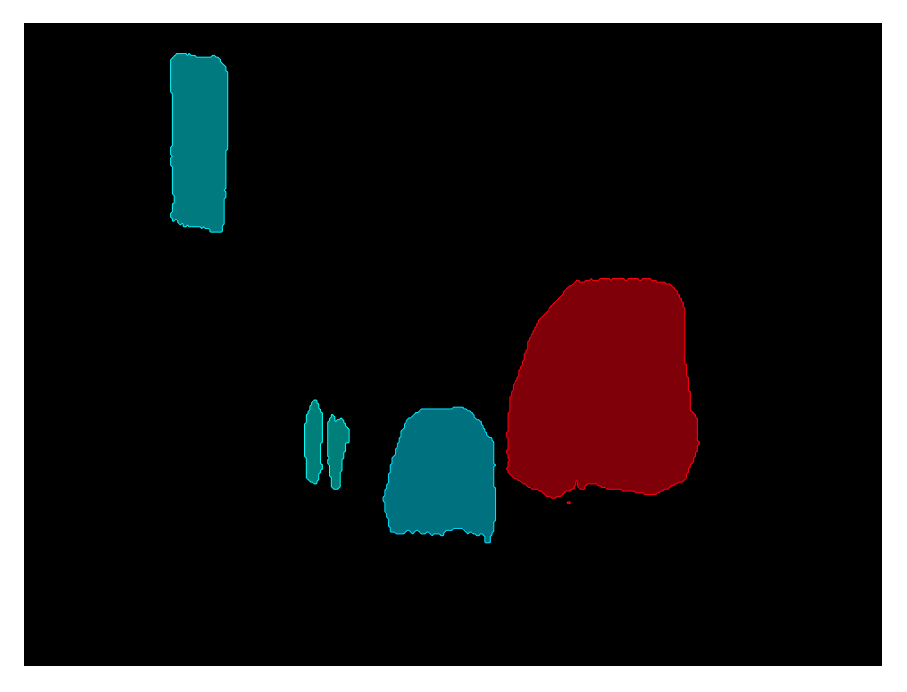

elapsed time for detection: 1.930857s
{'rois': array([[206, 191, 292, 269],
       [ 12,  77, 118, 115],
       [210, 154, 259, 168],
       [215, 167, 261, 183],
       [142, 267, 276, 379]], dtype=int32), 'class_ids': array([ 3, 10,  1,  1,  6], dtype=int32), 'scores': array([0.9789929 , 0.91704303, 0.718218  , 0.70833194, 0.70616454],
      dtype=float32), 'masks': array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False

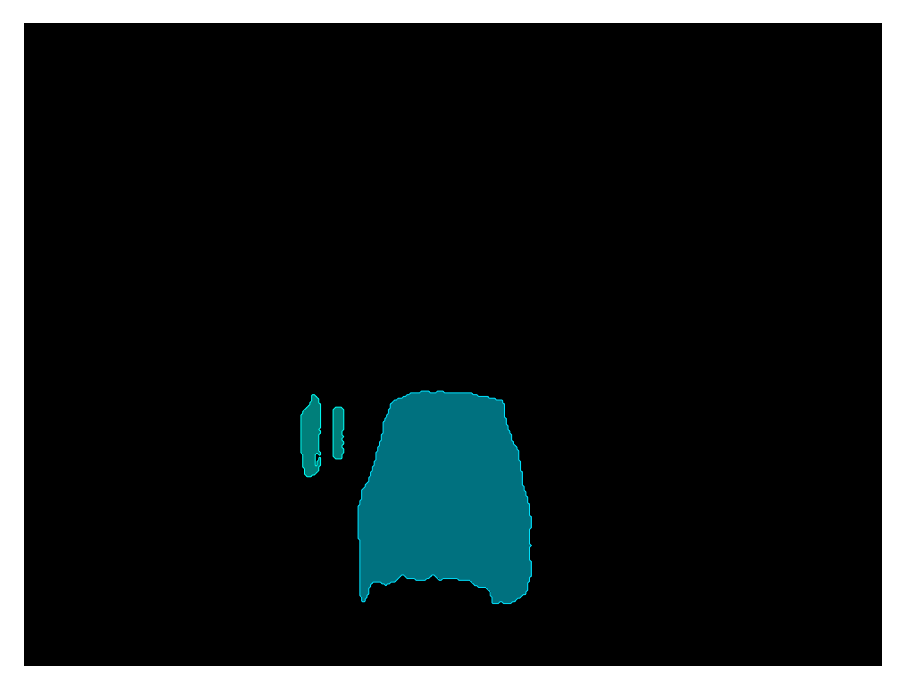

elapsed time for detection: 1.143443s
{'rois': array([[205, 153, 256, 169],
       [195, 175, 343, 295],
       [214, 171, 245, 180]], dtype=int32), 'class_ids': array([1, 3, 1], dtype=int32), 'scores': array([0.95149326, 0.782048  , 0.71951634], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
      

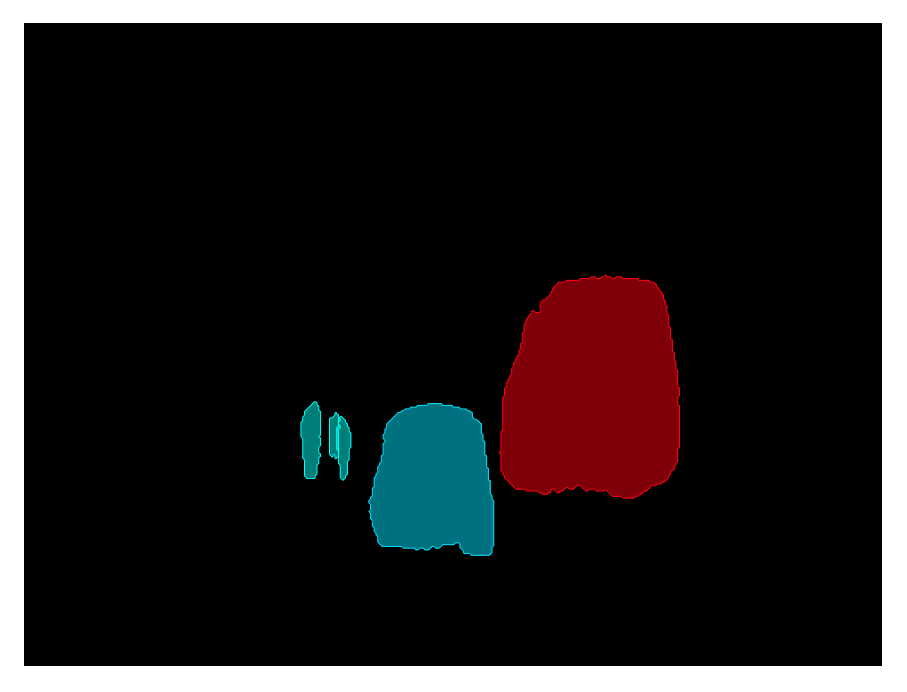

elapsed time for detection: 0.921877s
{'rois': array([[208, 153, 257, 167],
       [218, 174, 256, 184],
       [215, 169, 251, 178],
       [206, 187, 299, 268],
       [139, 264, 278, 369]], dtype=int32), 'class_ids': array([1, 1, 1, 3, 6], dtype=int32), 'scores': array([0.9658469 , 0.8999144 , 0.8930365 , 0.7541104 , 0.73230135],
      dtype=float32), 'masks': array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, Fal

In [7]:
%%time
# Detection
times = []
counter = 0


for image in images:
    # Run detection
    start = datetime.datetime.now()
    results = model.detect([image], verbose=1)
    stop = datetime.datetime.now()
    t = (stop-start).total_seconds()
    times.append(t)
    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, counter, r['scores'])
    counter = counter+1
    print("elapsed time for detection: {}s".format(t))
    print(r)
    
    #display_images(images)
#print("median FPS: {}".format(1./np.median(times)))

In [8]:
print("median FPS: {}".format(1./np.median(times)))
print(np.median(times))


median FPS: 1.0679744369638768
0.936352


In [9]:
import numpy as np
import cv2
import time
from mrcnn.visualize import display_instances

cap = cv2.VideoCapture(0)
cnt = 0
while(cnt<500):
    ret, frame = cap.read()
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if cnt%100==0:
        results = model.detect([frame], verbose=1)
        r = results[0]
        visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'],show_mask=True)
        
    cnt+=1
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'mrcnn'